<h1> Fine-tuning & Testing XLM-Roberta on English-translated & English Data </h1>
Carley Reardon

In [1]:
import pandas as pd

# first import our translated and original data
e_prep_path = "/projectnb/cs505/reardonc/CS505-Spring-MultiLingual-Twitter-Classification/data/preprocessed/english/"
a_transl_path = "/projectnb/cs505/reardonc/CS505-Spring-MultiLingual-Twitter-Classification/data/translated/arabic/"

e_train_df = pd.read_csv(e_prep_path+"english_train_tweets.csv")
e_test_df = pd.read_csv(e_prep_path+"english_test_tweets.csv")
a_test_df = pd.read_csv(a_transl_path+"arabic_test_tweets.csv")

print("English Train Tweets: "+str(e_train_df.shape))
print(e_train_df.head(5))
print("")
print("English Test Tweets: "+str(e_test_df.shape))
print(e_test_df.head(5))
print("")
print("Arabic-to-English Test Tweets: "+str(a_test_df.shape))
print(a_test_df.head(5))
print("")

English Train Tweets: (21124, 4)
                   id sentiment  \
0  264183816548130816  positive   
1  263405084770172928  negative   
2  262163168678248449  negative   
3  264249301910310912  negative   
4  262682041215234048   neutral   

                                            original  \
0  Gas by my house hit $3.39!!!! I\u2019m going t...   
1  Theo Walcott is still shit\u002c watch Rafa an...   
2  its not that I\u2019m a GSP fan\u002c i just h...   
3  Iranian general says Israel\u2019s Iron Dome c...   
4  Tehran\u002c Mon Amour: Obama Tried to Establi...   

                                        preprocessed  
0  gas house hit $ 3.39 i\u2019 m going chapel hi...  
1  theo walcott shit\u002c watch rafa johnny deal...  
2  i\u2019 m gsp fan\u002c hate nick diaz can\u20...  
3  iranian general says israel\u2019s iron dome c...  
4  tehran\u002c mon amour obama tried establish t...  

English Test Tweets: (28333, 4)
                   id sentiment  \
0  264238274963451904

In [2]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install sentencepiece

Defaulting to user installation because normal site-packages is not writeable


In [4]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
import torch

# CODE BASED ON TUTORIAL BY CHRIS MCCORMICK AND NICK RYAN

# set up data for model
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base', do_lower_case=True)

input_ids = []
attention_masks = []
labels = []

for idx, row in e_train_df.iterrows():
    #print(row)
    tw = str(row['preprocessed'])
    if row['sentiment'] == "positive":
        label = 1
    elif row['sentiment'] == "negative":
        label = 0
    else:
        label = 2
    encoded_dict = tokenizer.encode_plus(
                        tw,                      
                        add_special_tokens = True,
                        max_length = 128,
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )   
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    labels.append(label)

for idx, row in e_test_df.iterrows():
    tw = str(row['preprocessed'])
    if row['sentiment'] == "positive":
        label = 1
    elif row['sentiment'] == "negative":
        label = 0
    else:
        label = 2
    encoded_dict = tokenizer.encode_plus(
                        tw,                      
                        add_special_tokens = True,
                        max_length = 128,
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )   
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    labels.append(label)
    
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [5]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# CODE BASED ON TUTORIAL BY CHRIS MCCORMICK AND NICK RYAN

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

44,511 training samples
4,946 validation samples


In [6]:
# CODE BASED ON TUTORIAL BY CHRIS MCCORMICK AND NICK RYAN

batch_size = 16
 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [8]:
# CODE BASED ON TUTORIAL BY CHRIS MCCORMICK AND NICK RYAN

# Load XLM-R
xlm_model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", # Use the base XLM-R model, with an uncased vocab.
    num_labels = 3, # The number of output labels--3 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
xlm_model.cuda()

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [9]:
from transformers import AdamW, get_linear_schedule_with_warmup

# CODE BASED ON TUTORIAL BY CHRIS MCCORMICK AND NICK RYAN

optimizer_xlm = AdamW(xlm_model.parameters(),
                  lr = 5e-6,
                  eps = 1e-8
                )
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer_xlm, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [10]:
device = torch.device("cuda")

In [11]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [12]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [13]:
import random

def training_helper(model, train_dataloader, validation_dataloader, optimizer, scheduler, 
                    seed_val=42, epochs=3, ):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    training_stats = []

    total_t0 = time.time()

    # For each epoch...
    for epoch_i in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()
        total_train_loss = 0
        
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()        

            result = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels,
                        return_dict=True)

            loss = result.loss
            logits = result.logits

            total_train_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))
            
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            with torch.no_grad():        
                result = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)

            loss = result.loss
            logits = result.logits

            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            total_eval_accuracy += flat_accuracy(logits, label_ids)
            

        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    return training_stats

In [14]:
xlm_training_stats = training_helper(xlm_model, train_dataloader, val_dataloader, optimizer_xlm, scheduler, epochs=4)


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  2,782.    Elapsed: 0:00:06.
  Batch    80  of  2,782.    Elapsed: 0:00:12.
  Batch   120  of  2,782.    Elapsed: 0:00:17.
  Batch   160  of  2,782.    Elapsed: 0:00:23.
  Batch   200  of  2,782.    Elapsed: 0:00:29.
  Batch   240  of  2,782.    Elapsed: 0:00:35.
  Batch   280  of  2,782.    Elapsed: 0:00:41.
  Batch   320  of  2,782.    Elapsed: 0:00:46.
  Batch   360  of  2,782.    Elapsed: 0:00:52.
  Batch   400  of  2,782.    Elapsed: 0:00:58.
  Batch   440  of  2,782.    Elapsed: 0:01:04.
  Batch   480  of  2,782.    Elapsed: 0:01:10.
  Batch   520  of  2,782.    Elapsed: 0:01:16.
  Batch   560  of  2,782.    Elapsed: 0:01:21.
  Batch   600  of  2,782.    Elapsed: 0:01:27.
  Batch   640  of  2,782.    Elapsed: 0:01:33.
  Batch   680  of  2,782.    Elapsed: 0:01:39.
  Batch   720  of  2,782.    Elapsed: 0:01:45.
  Batch   760  of  2,782.    Elapsed: 0:01:51.
  Batch   800  of  2,782.    Elapsed: 0:01:56.
  Batch   840  of

  Batch 1,160  of  2,782.    Elapsed: 0:02:48.
  Batch 1,200  of  2,782.    Elapsed: 0:02:54.
  Batch 1,240  of  2,782.    Elapsed: 0:03:00.
  Batch 1,280  of  2,782.    Elapsed: 0:03:06.
  Batch 1,320  of  2,782.    Elapsed: 0:03:12.
  Batch 1,360  of  2,782.    Elapsed: 0:03:17.
  Batch 1,400  of  2,782.    Elapsed: 0:03:23.
  Batch 1,440  of  2,782.    Elapsed: 0:03:29.
  Batch 1,480  of  2,782.    Elapsed: 0:03:35.
  Batch 1,520  of  2,782.    Elapsed: 0:03:41.
  Batch 1,560  of  2,782.    Elapsed: 0:03:46.
  Batch 1,600  of  2,782.    Elapsed: 0:03:52.
  Batch 1,640  of  2,782.    Elapsed: 0:03:58.
  Batch 1,680  of  2,782.    Elapsed: 0:04:04.
  Batch 1,720  of  2,782.    Elapsed: 0:04:10.
  Batch 1,760  of  2,782.    Elapsed: 0:04:15.
  Batch 1,800  of  2,782.    Elapsed: 0:04:21.
  Batch 1,840  of  2,782.    Elapsed: 0:04:27.
  Batch 1,880  of  2,782.    Elapsed: 0:04:33.
  Batch 1,920  of  2,782.    Elapsed: 0:04:39.
  Batch 1,960  of  2,782.    Elapsed: 0:04:44.
  Batch 2,000

In [15]:
import pickle

# save model
pickle.dump(xlm_model, open("./xlm_english.pkl", "wb" ) )

/share/pkg.7/pytorch/1.5/install/3.7/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [15]:
# show training stats
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=xlm_training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.84,0.76,0.66,0:06:44,0:00:11
2,0.74,0.73,0.67,0:06:46,0:00:11
3,0.69,0.74,0.68,0:06:44,0:00:11
4,0.67,0.73,0.68,0:06:44,0:00:11


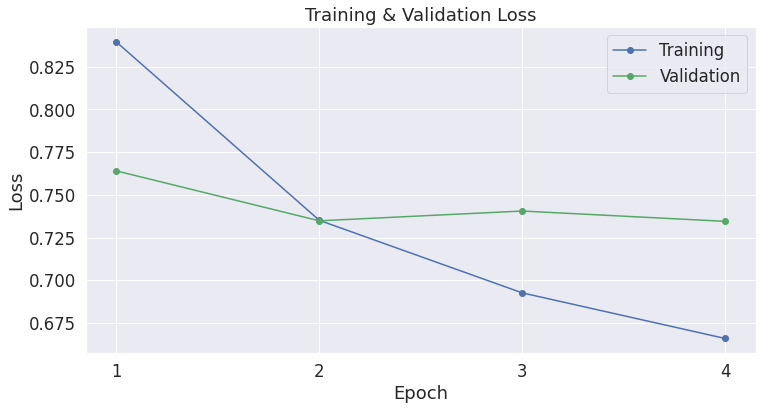

In [16]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [17]:
# test on arabic tweets
test_input_ids = []
test_attention_masks = []
test_labels = []

# For every sentence...
for idx, row in a_test_df.iterrows():
    tw = str(row['translated'])
    if row['sentiment'] == "positive":
        label = 1
    elif row['sentiment'] == "negative":
        label = 0
    else:
        label = 2
    encoded_dict = tokenizer.encode_plus(
                        tw,                      
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )    
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])
    test_labels.append(label)

# Convert the lists into tensors.
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 16  

# Create the DataLoader.
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr4/cs640/reardonc/.local/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [18]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode
xlm_model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = xlm_model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           return_dict=True)
        
    logits = result.logits
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,353 test sentences...
    DONE.


In [19]:
xlm_accuracies = []
for i in range(len(predictions)):
    xlm_accuracies += [flat_accuracy(predictions[i], true_labels[i])]

xlm_mean = sum(xlm_accuracies)/len(xlm_accuracies)
#print('Accuracies for each test batch: ', xlm_accuracies)
print('Average test accuracy: ', xlm_mean)

Average test accuracy:  0.5965608465608465
